In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
import autograd.numpy as np
import math
import pandas as pd
from mlrefined_libraries import calculus_library as calclib

%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Part 4: Automatic Differentiation

Here we discuss the *forward mode* of Automatic Differentiation, a natural and direct implementation of the method for calculating derivatives 'by hand' using a computation graph as discussed in the previous post.

Leveraging closed form derivative rules - instead of e.g., numerical approximation - the Automatic Differentiator it is typically more accurate than the Numerical Differentiation calculator discussed in the second post of this series, and has no parameters that require tuning.

Press the botton 'Toggle code' below to toggle code on and off for entire this presentation.  For this presentation it is recommended to keep the code ON.

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1.  Basic design elements of the Automatic Differentiator

## 1.1 Information flow and construction of the computation graph

 <p><img src="../../mlrefined_images/calculus_images/func_2_p0.png" width="85%" height="auto"></p>

- The computation graph is a powerful tool for recursively describing how a mathematical function is constructed, how it is evaluated, and how its derivative is formed.  

- In particular we have seen how *recursively sweeping forward through a computation graph* breaks down large derivative calculations into a long sequence of much smaller ones.

<p><img src="../../mlrefined_images/calculus_images/func_2_p0.png" width="85%" height="auto"></p>

- Because recursive algorithms are so naturally dealt with using for loops / while loops, the computation graph provides a bridge for thinking about how to perform / organize computations involving mathematical functions - like e.g., derivative calculations - on a computer instead of by hand.


- Because AD calculations will be made using the computation graph, our first task is to decide how the graph will be constructed by our AD algorithm.  

<p><img src="../../mlrefined_images/calculus_images/func_2_p0.png" width="85%" height="auto"></p>

- Essentially we have two choices: we can either parse the input function ahead of time and construct its computation graph *explicitly*, or build our AD algorithm such that the graph is constructed *implicitly* and is never stored as a whole.  


- Each approach has strengths and weaknesses but we go with the latter approach and derive an AD algorithm which constructs the computation graph implicitly because it is simple and lightweight, and requires fewer moving parts (like e.g., a parser).

## 1.2  What do we need to track while computing?

> The AD calculator employs derivative rules in precisely the same manner as we applied by hand but produces a *program-based function* of the derivative, i.e., a subroutine that provides correct evaluation of the mathematical function and its derivative for any input desired.  

In other words, the fundamental object on which the AD calculator operates on is a tuple of values consisting of the evaluation of the function and its derivative at a point.

As we further develop the AD calculator we will see that a very convenient way to store, transport, and update these two values is by incorporating them into a simple Python class-object.

We define this simple class below - again instances of this class are simply a convenient way of holding onto the current evaluation of a function (called *val* for short) as well as its derivative value (called *der*). 

For those wanting a good introduction to Python classes in the context of mathematical functions see e.g., [this excellent book](http://hplgit.github.io/primer.html/doc/pub/class/class-readable.html).

In [4]:
class MyTuple:
    '''
    The basic object manipulated by an AD calculator
    Instances of this class is a tuple containining one 
    function/derivative evaluation.
    '''
    def __init__(self,**kwargs):
        # variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1    
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']

## 1.3  Creating derivative rules for elementary functions

With our base object taken care of we can quickly code up the derivative rules for elementary functions contained in Table 1 of the previous post, which we repeat here for convenience.

<br>
  <center>
  <caption>Table 1: Derivative formulae for elementary functions</caption>
  </center> 
<table>
  <col width="160">
  <col width="100">
  <col width="100">
<thead>
<tr>
    <th>elementary function</th>
    <th>equation</th> 
    <th>derivative</th>
  </tr>
  </thead>
  <tbody>
    <tr>
    <td>constant</td>
    <td>$c$</td>
    <td>$0$</td>
  </tr>
  <tr>
    <td>monomial (degree $p\neq 0$)</td>
    <td>$w^p$</td>
    <td>$pw^{p-1}$</td>

  </tr>
    <tr>
    <td>sine</td>
    <td>$\text{sin}(w)$</td>
    <td>$\text{cos}(w)$</td>
  </tr>
  <tr>
    <td>cosine</td>
    <td>$\text{cos}(w)$</td>
    <td>$-\text{cos}(w)$</td>
  </tr>
  <tr>
    <td>exponential</td>
    <td>$e^w$</td>
    <td>$e^w$</td>
  </tr>
  <tr>
    <td>logarithm</td>
    <td>$\text{log}(w)$</td>
    <td>$\frac{1}{w}$</td>
  </tr>
    <tr>
    <td>hyperbloic tangent</td>
    <td>$\text{tanh}(w)$</td>
    <td>$1 - \text{tanh}^2(w)$</td>
  </tr>
      <tr>
    <td>rectified linear unit (ReLU) </td>
    <td>$\text{max}\left(0,w\right)$</td>
    <td>$\begin{cases}0 & w\leq0\\1 & w>0\end{cases}$</td>
  </tr>
  </tbody>
</table>

Since we are tracing both the function and derivative evaluation in order to create one of these rules as a Python function we need to 

- define how the elementary function transforms the input function value

- define how the corresponding derivative rule transforms the input derivative value. 

#### <span style="color:#a50e3e;">Example 1. </span> Programming the derivative of $g(w) = \text{sin}(w) \Longleftrightarrow \frac{\mathrm{d}}{\mathrm{d}w}g(w) = \text{cos}(w)$

In [5]:
# our implementation of the sinusoid rule from Table 1
def sin(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.sin(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = np.cos(a.val)*a.der
    
    # Return updated object
    return b

- Here we input $a$, an ```MyTuple``` object with a current function and derivative value, and create a new instance to contain their updates called $b$.  

- To get the new function update

```
b.val = np.sin(a.val)
```

we simply pass the current value through a sinusoid.  

- The corresponding derivative value update 

```
b.der = np.cos(a.val)*a.der
```

we apply an elementary derivative formula and the *chain rule*.  This is why we multiply ```np.cos(a.val)``` by ```a.der``` in the update.

We can now test our sinusoid function over a few input points, as is done in the next cell.  

In [6]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w)

# initialize our AutoDiff object at each point
a1 = MyTuple(val = 0); a2 = MyTuple(val = 0.5)

# evaluate
result1 = g(a1); result2 = g(a2)

# print results
print ('function value at ' + str(0) + ' = ' + str(result1.val))
print ('derivaive value at ' + str(0) + ' = ' + str(result1.der))

print ('function value at ' + str(0.5) + ' = ' + str(result2.val))
print ('derivaive value at ' + str(0.5) + ' = ' + str(result2.der))

function value at 0 = 0.0
derivaive value at 0 = 1.0
function value at 0.5 = 0.479425538604
derivaive value at 0.5 = 0.87758256189


Looks good! lets evaluate over a large range of inputs and visualize both the function and derivative values.  

<IPython.core.display.Javascript object>


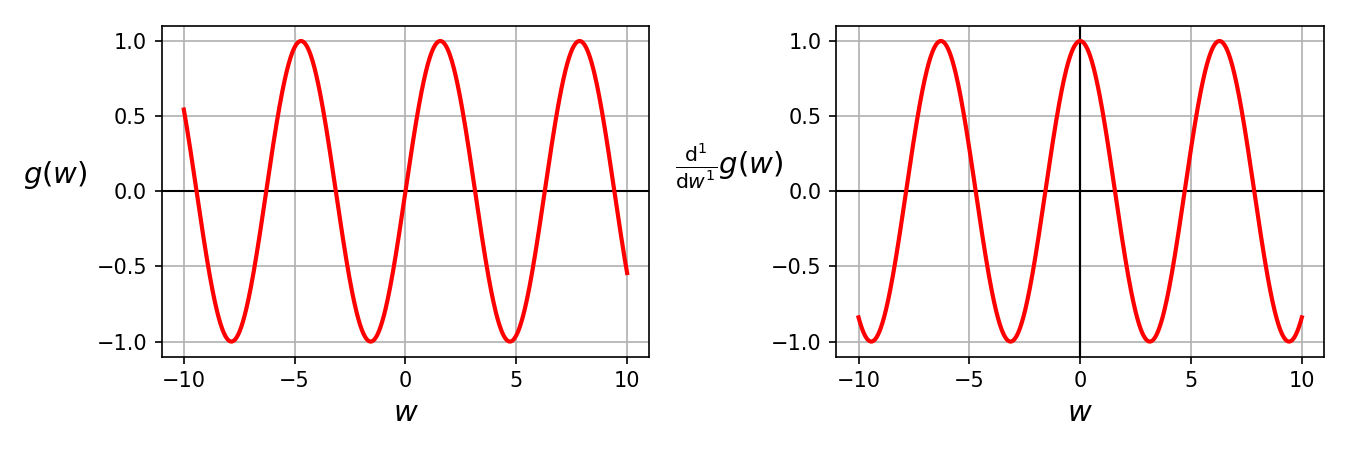

In [8]:
# define a function using our AD components
g = lambda w: sin(w)

# use custom plotter to evaluate function and derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

And indeed this is correct: the function evaluation is sine and the derivative evaluation is cosine over the entire input range.

We can just as easily define a cosine function as well, and do so in the next Python cell.

In [31]:
# our implementation of the cosine rule from Table 1
def cos(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.cos(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = -np.sin(a.val)*a.der
    
    # Return updated object
    return b

#### <span style="color:#a50e3e;">Example 2. </span> Computing the derivative of $g(w) = w^n \Longleftrightarrow \frac{\mathrm{d}}{\mathrm{d}w}g(w) = n\,w^{n-1}$

We can define a power rule precisely as done with the sinusoid function in the previous example: 
    - updating the current function evaluation using the elementary function
    - and the current derivative value using the corresponding derivative rule from Table 1.  

Once again we must include an instance of the chain rule with our derivative update.

In [10]:
# our implementation of the power rule from Table 1 
def power(a,n):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = a.val**n

    # Produce new derivative value - we need to use the chain rule here!
    b.der = n*(a.val**(n-1))*a.der
    
    # Return updated object
    return b

And we can test out this function by evaluating/plotting over a large range of inputs, say the third degree monomial $w^2$.

<IPython.core.display.Javascript object>


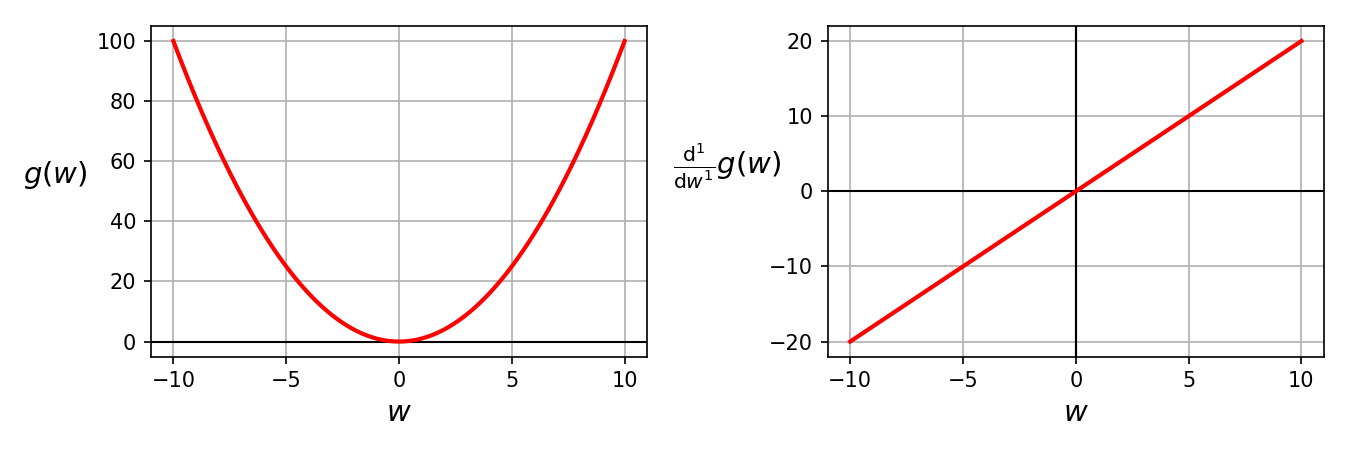

In [11]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: power(w,2)

# use the custom plotting function above to plot function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Again everything looks good!

#### <span style="color:#a50e3e;">Example 3. </span> Computing the derivative of $g(w) = \text{tanh}(w) \Longleftrightarrow \frac{\mathrm{d}}{\mathrm{d}w}g(w) = 1 - \text{tanh}^2(w) $

As with the previous examples we can define the $\text{tanh}$ function, making sure to include the chain rule with our update of the derivative value.

In [12]:
# our implementation of the power rule from Table 1 
def tanh(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.tanh(a.val)

    # Produce new derivative value
    b.der = (1 - np.tanh(a.val)**2)*a.der
    
    # Return updated object
    return b

And we can test our new tanh function over a range of values.

<IPython.core.display.Javascript object>


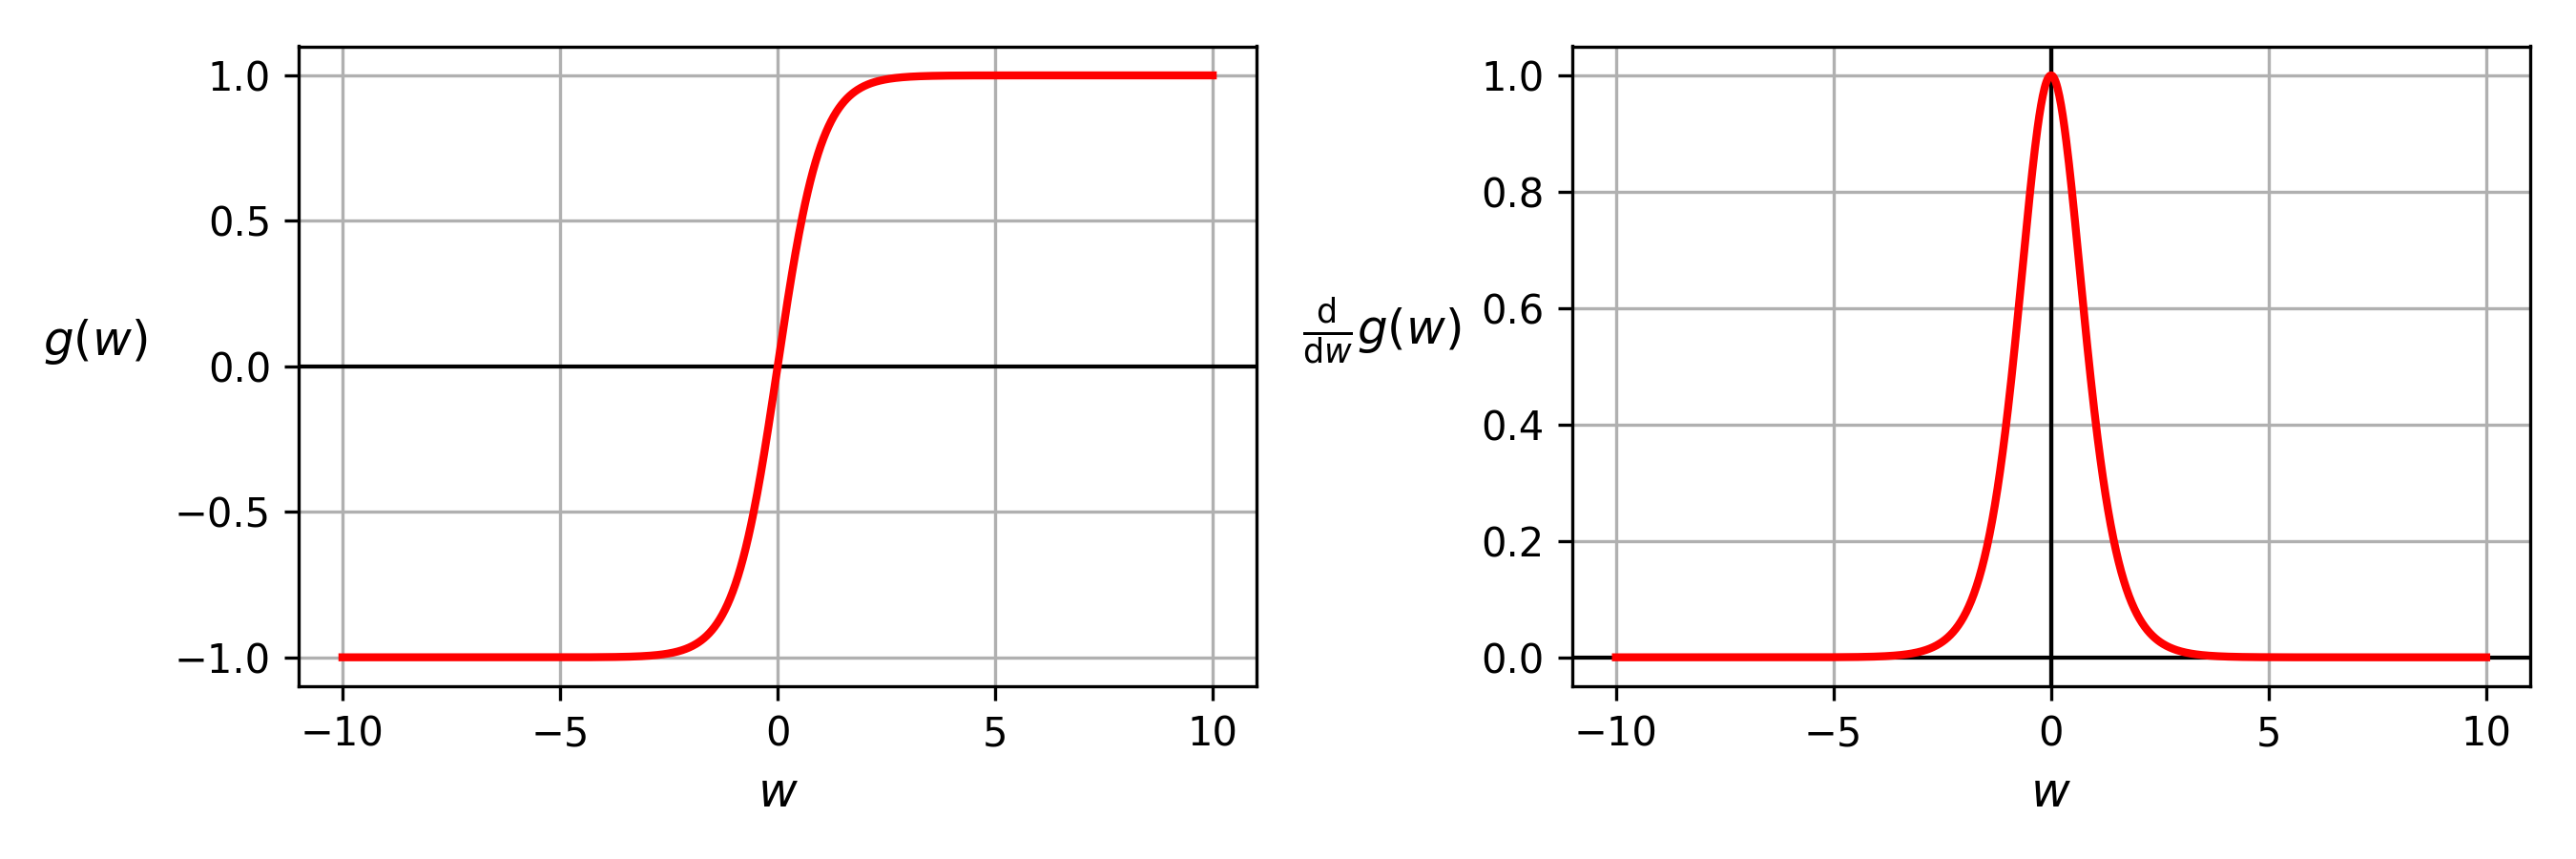

In [19]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w)

# use the custom plotting function above to plot function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Correct again!

We can of course verify that this is correct by plotting the function and derivative equations given in the table.  

<IPython.core.display.Javascript object>


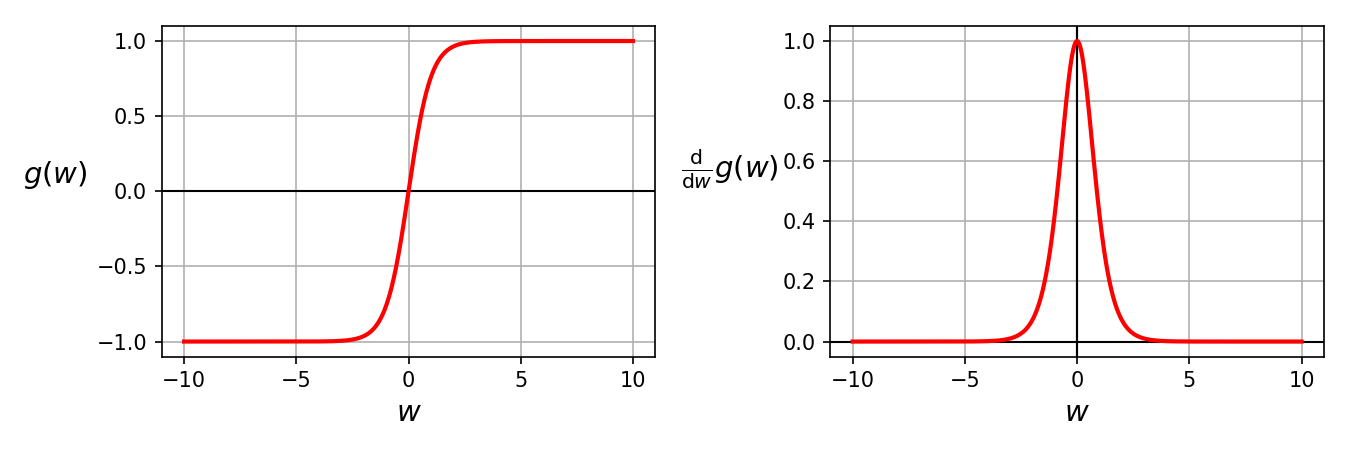

In [16]:
# define function and its derivative equations using numpy
g = lambda w: np.tanh(w)
dgdw = lambda w: (1 - np.tanh(w)**2)

# plot both
calclib.plotter.derval_eq_plot(g,dgdw)

#### <span style="color:#a50e3e;">Example 4. </span> Computing the derivative of $g(w) = \text{log}(w)$

Mirroring the previous examples we can code up the derivative rule for log as follows.

In [17]:
# our implementation of the sinusoid rule from Table 1
def log(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.log(a.val)

    # Produce new derivative value
    b.der = (1/a.val)*a.der
    
    # Return updated object
    return b

And quickly testing it out, we see that it indeed works.

<IPython.core.display.Javascript object>


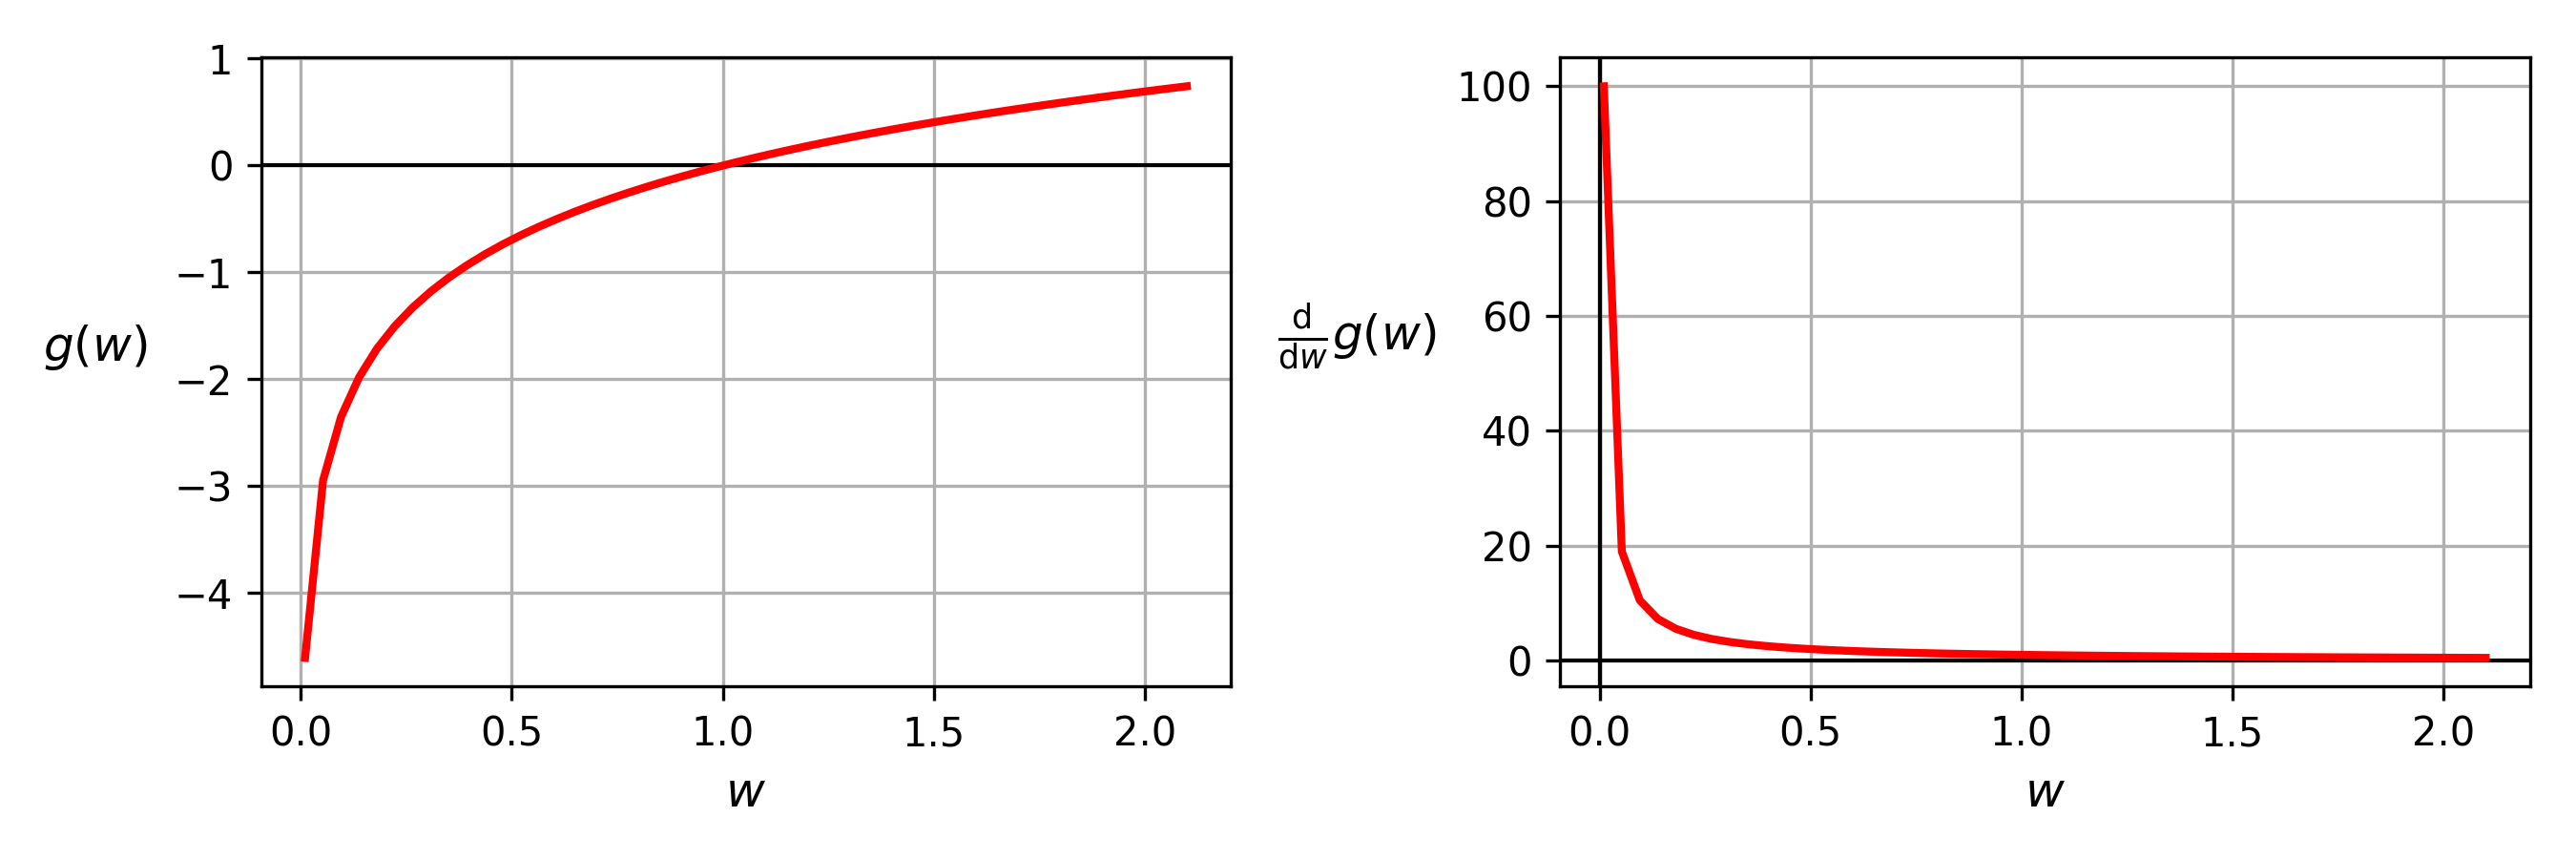

In [30]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: log(w)
w = np.linspace(0.01,2.1000)

# use the custom plotting function above to plot function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

## 1.4 Creating derivative rules for elementary operations

In the previous post we described derivative rules for each elementary operation, which we repeat below for convenience. 

<br>
<center>
  <caption>Table 2: Derivative formulae for elementary operations</caption>
</center>
<table>
  <col width="820">
  <col width="180">
  <col width="650">
<thead>
<tr>
    <th>operation</th> 
    <th>equation</th>
    <th>derivative rule</th>    
  </tr>
  </thead>
  <tbody>
     <tr>
    <td> addition of a constant $c$ </td>
    <td> $g(w) + c$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(g(w) + c\right)=  \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
    <tr>
    <td> multiplication by a constant $c$ </td>
    <td> $cg(w)$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(cg(w)\right)=  c\frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr>  
  <tr>
  <td> addition of functions (often called the summation rule)</td>
    <td> $f(w) + g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w) + g(w))=  \frac{\mathrm{d}}{\mathrm{d}w}f(w) + \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
  <tr>
  <td> multiplication of functions (often called the product rule) </td>
    <td> $f(w)g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w)\cdot g(w))=  \left(\frac{\mathrm{d}}{\mathrm{d}w}f(w)\right)\cdot g(w) + f(w)\cdot \left(\frac{\mathrm{d}}{\mathrm{d}w}g(w)\right)$
    </td>
  </tr>
  <tr>
  <td> composition of functions (often called the chain rule)</td>
    <td> $f(g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(g(w)))= \frac{\mathrm{d}}{\mathrm{d}g}f(g) \cdot \frac{\mathrm{d}}{\mathrm{d}w}g(w)$
  </td>
  </tr>
  <tr>
  <td> maximum of two functions </td>
    <td> $\text{max}(f(w),\,g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(\text{max}(f(w),\,g(w))) = \begin{cases}\frac{\mathrm{d}}{\mathrm{d}w}f\left(w\right) & \text{if}\,\,\,f\left(w\right)\geq g\left(w\right)\\\frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) & \text{otherwise}\end{cases}$</td>
  </tr> 
  </tbody>
</table>

As with the derivative formulae for elementary functions, implementing these rules means providing - in each case - an update for the function and derivative value.  We walk through several examples.

#### <span style="color:#a50e3e;">Example 5. </span> Programming the addition rules

- Here we knock out both of the addition rules in Table 2: defining the derivative of a function and constant, and two functions.  

- A simple switch or if/else statement is used below to sort between these two cases.

In [20]:
# our implementation of the addition rules from Table 2
def add(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a + b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val + b
        c.der = a.der
    else: # both inputs are MyTuple objects, i.e., functions
        c.val = a.val + b.val
        c.der = a.der + b.der
    
    # Return updated object
    return c

With the addition rules taken care of above we can combine it with the elementary function derivatives programmed earlier.

- for example

\begin{equation}
\text{sin}(w) + w
\end{equation}

- we write this as ``add(sin(w),w)`` in Python using the nomenclature we have thus far designed

<IPython.core.display.Javascript object>


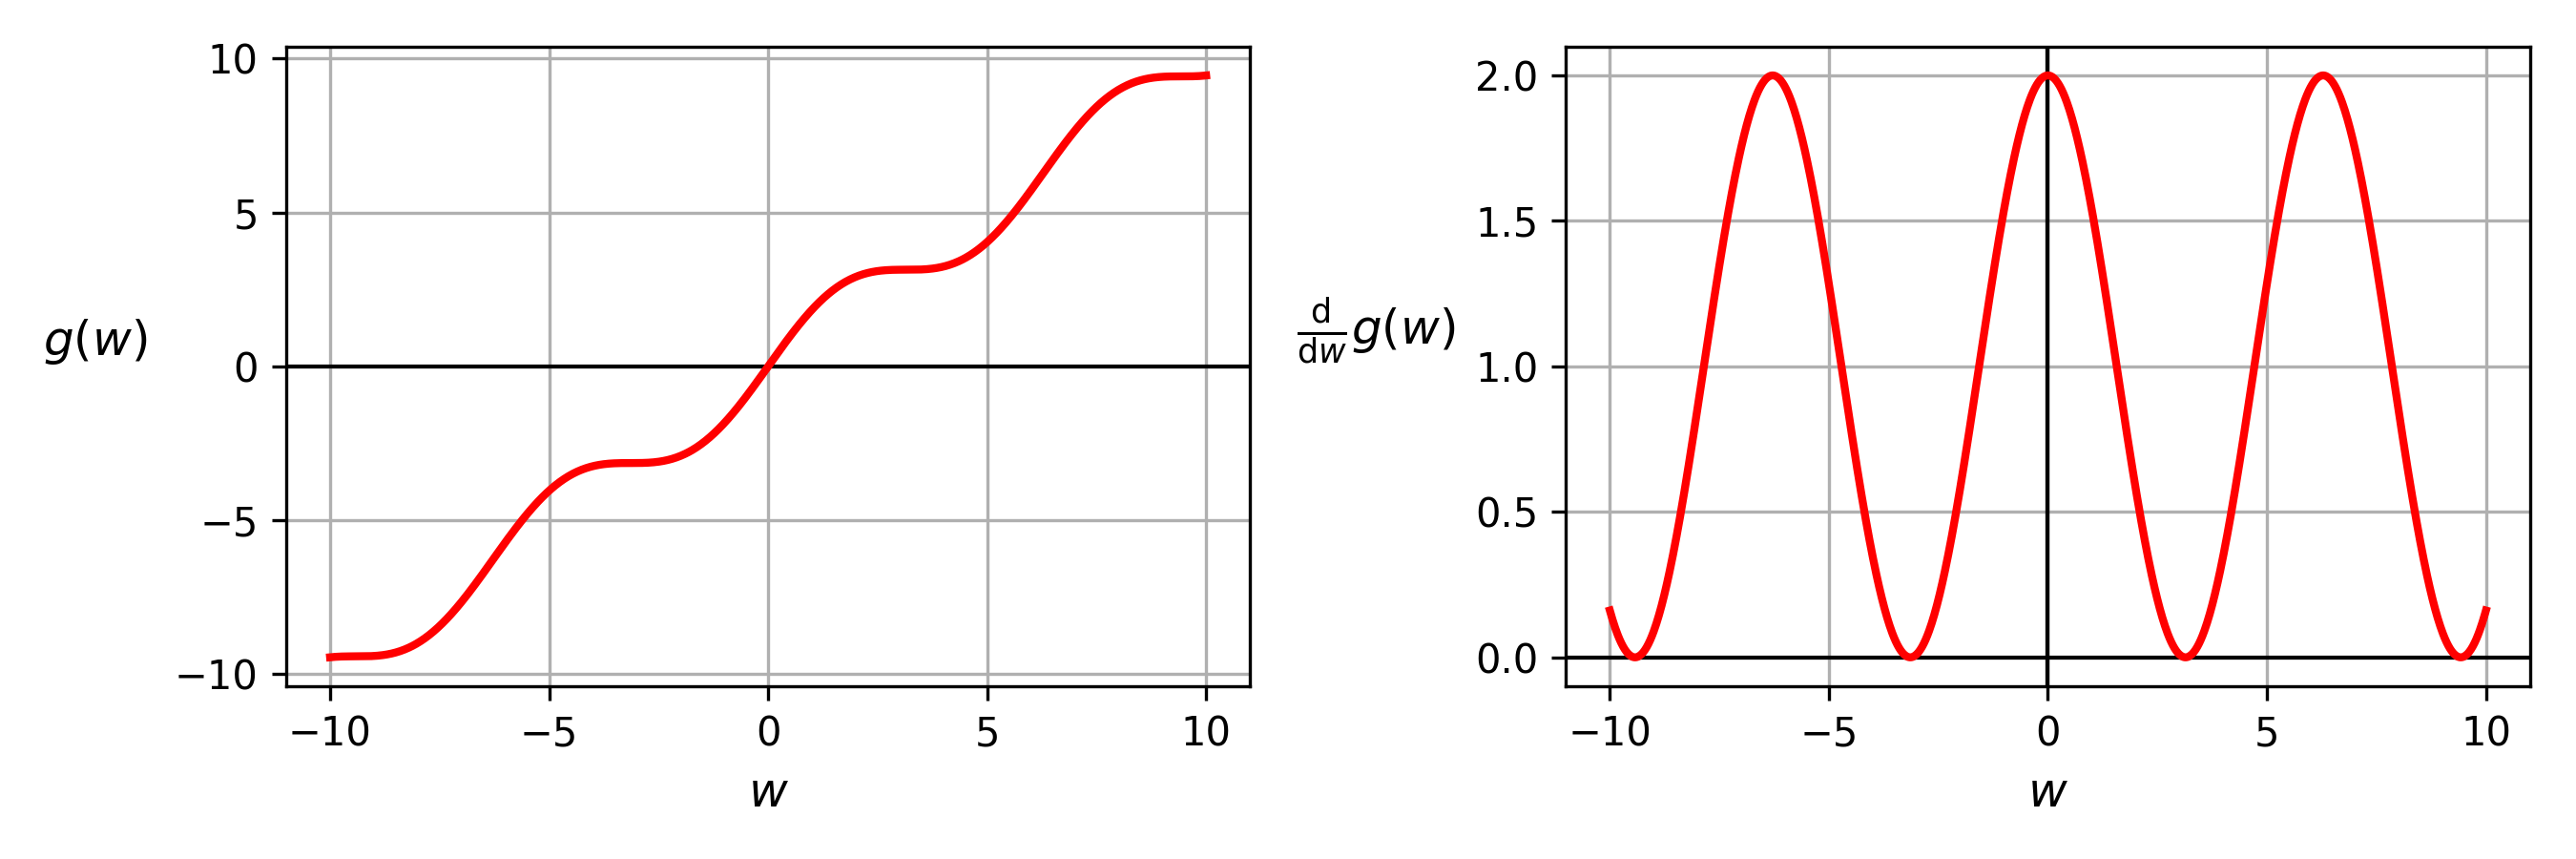

In [21]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: add(sin(w),w)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

- **Note:** the computation graph for our input function is *implicitly* constructed and computed on when we pass a MyTuple object through the function ```add(sin(w),w)```.

-  In other words, while we do not have the computation graph itself we are traversing it to construct the function/derivative values just as we did by hand in the previous post.

#### <span style="color:#a50e3e;">Example 6. </span> Coding up the multiplication rules

- we also have several multiplication rules - what to do with the product of a constant and a function, and two functions


- we can also  wrap both rules up into one Python function, using a switch or if/else to distinguish between them.

In [22]:
# our implementation of the addition rules from Table 2
def multiply(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()

    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a*b.val
        c.der = a*b.der
    elif type(b) != MyTuple:
        c.val = a.val*b
        c.der = a.der*b

    else: # both inputs are MyTuple objects i.e., functions
        c.val = a.val*b.val
        c.der = a.der*b.val + a.val*b.der     # product rule
    
    # Return updated object
    return c

With the multiplication rules taken care of above we can try it out

- for example

\begin{equation}
\text{sin}(w)\times w^2
\end{equation}

<IPython.core.display.Javascript object>


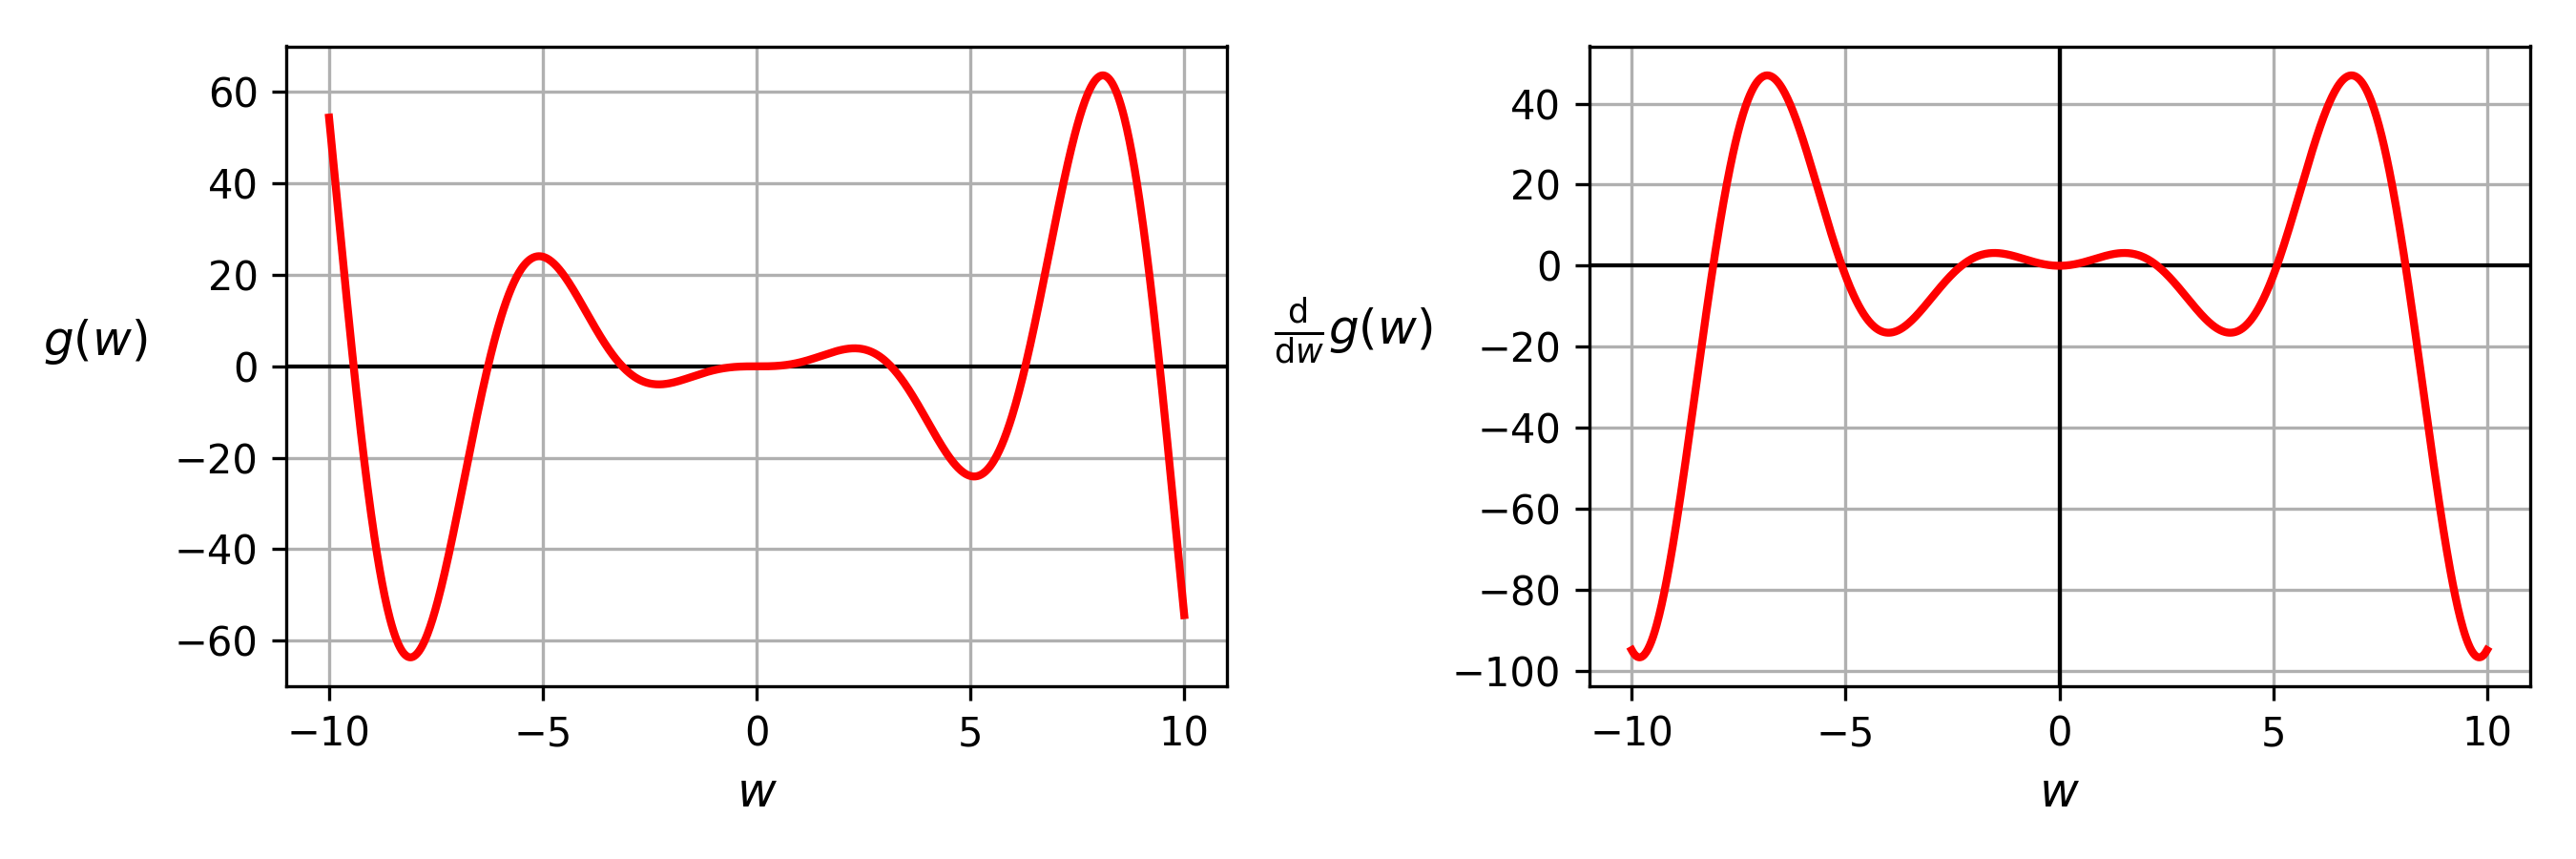

In [23]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: multiply(sin(w),power(w,2))

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

- again here the computation graph is explicitly constructed and computed on when we pass a MyTuple object through the function ```multiply(sin(w),power(w,2))```.

## 1.5  Improving usability via operator overloading

With our current AD calculator setup we have just seen that in order to compute the derivative of 

$$
g(w) = \text{sin}(w) + w
$$

we use the somewhat clunky Python notation
                    
                        add(sin(w),w)

to invoke the summation derivative rule, and compute the derivative of the function. 

- here we discuss how to *overload operators* in Python to make the call above look more similar to the algebraic form of the function

- Python reserves symbols like ```+``` and ```*``` to denote a Python functions that perform standard addition and multiplication *on floating point objects*. 

 This means that if we try to use one of these symbols on our *MyTuple* object directly we will receive an error like 

    unsupported operand type(s) for +: 'MyTuple' and 'MyTuple'

because our objects differ from the intended input to Python's default addition function, the one assigned to the ```+``` operator.  We try this in the next Python cell, and indeed we provoke an error.

In [20]:
# create two MyTuple objects and try to use Python's built in function assigned to the + operator on them
a = MyTuple(); b = MyTuple();
a + b

TypeError: unsupported operand type(s) for +: 'MyTuple' and 'MyTuple'

- We have already defined an addition function for MyTuple objects, one that updates both function and derivative values, and can force Python to use this function whenever we write use symbol ```+``` in the context of MyTuple objects.  

- This is called *operator overloading*, in short we re-define the function Python uses when it sees a particular operator like ```+```.  

- Because we want the operator ```+``` to behave differently for MyTuple objects we must overload it in the class definition of MyTuple.  So, we can go back and add our ```add``` function in the MyTuple class definition.  

- In order to tell Python to use this function to overload the ```+``` operator we use the special function name ```__add__```, as shown in the abbreviated version of the ```add``` function below.

```
# our implementation of the addition rules from Table 2
def __add__(self,a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    .
    .
    .
    # Return updated object
    return c
``` 

- We can also do this on the fly, appending our ```add``` function to the class definition via the following calls

In [25]:
# this next line overloads the addition operator for our MyTuple objects, or in other words adds the 'add' function to our MyTuple class definition on the fly
MyTuple.__add__ = add

# overload the reverse direction so that a + b = b + a
MyTuple.__radd__ = add

We also overload the operator ```__radd__``` because in Python different functions can be assigned to ```+``` depending on the ordering of the two elements being operated on. 

i.e., we can assign different functions to ```+``` for each scenario

                    __add__: assigns operation to a + b
                   __radd__: assigns operation to b + a
                    
if we so desired.  

We want Python to interpret ```+``` with our objects so that these two are equal

                    a + b = b + a
                    
Since we want to treat both the same way, and so overload ```__radd__``` with our ```add``` function as well.

Now we can use the ```+``` symbol with our MyTuple objects, and Python will employ our own ```add``` function to combine the two objects.  We demonstrate this in the next Python cell.

In [22]:
# create two MyTuple objects and try to use Python's built in function assigned to the + operator on them
a = MyTuple(); b = MyTuple();
a + b
b + a

We can do precisely the same thing with other natural Python operators reserved for multiplication ```*```, subtraction ```-```, raising to a power ```**```, etc.,  

The more of these we overload appropriately the more user-friendly our AD calculator becomes.  

Since we have already made functions for multiplying and raising MyType objects to a power, we can overload these two operators on the fly.

In [26]:
# create two MyTuple objects and try to use Python's built in function assigned to the * operator on them
MyTuple.__mul__ = multiply

# overload the 'reverse multiplication' so that a*b = b*a
MyTuple.__rmul__ = multiply    

# create two MyTuple objects and try to use Python's built in function assigned to the ** operator on them
MyTuple.__pow__ = power

With these operators overloaded we can write out several of the previous examples more naturally, which we do in the next few Python cells.

#### <span style="color:#a50e3e;">Example 7. </span> Multiple more complicated examples written with overloaded operators

For example we calculated the derivative above as

$$
g(w) = \text{sin}(w)w^2
$$

which we first had to write as

                    multiply(sin(w),power(w,2))

Now we can write this derivative calculation much more naturally as

                    sin(w)*w**2

<IPython.core.display.Javascript object>


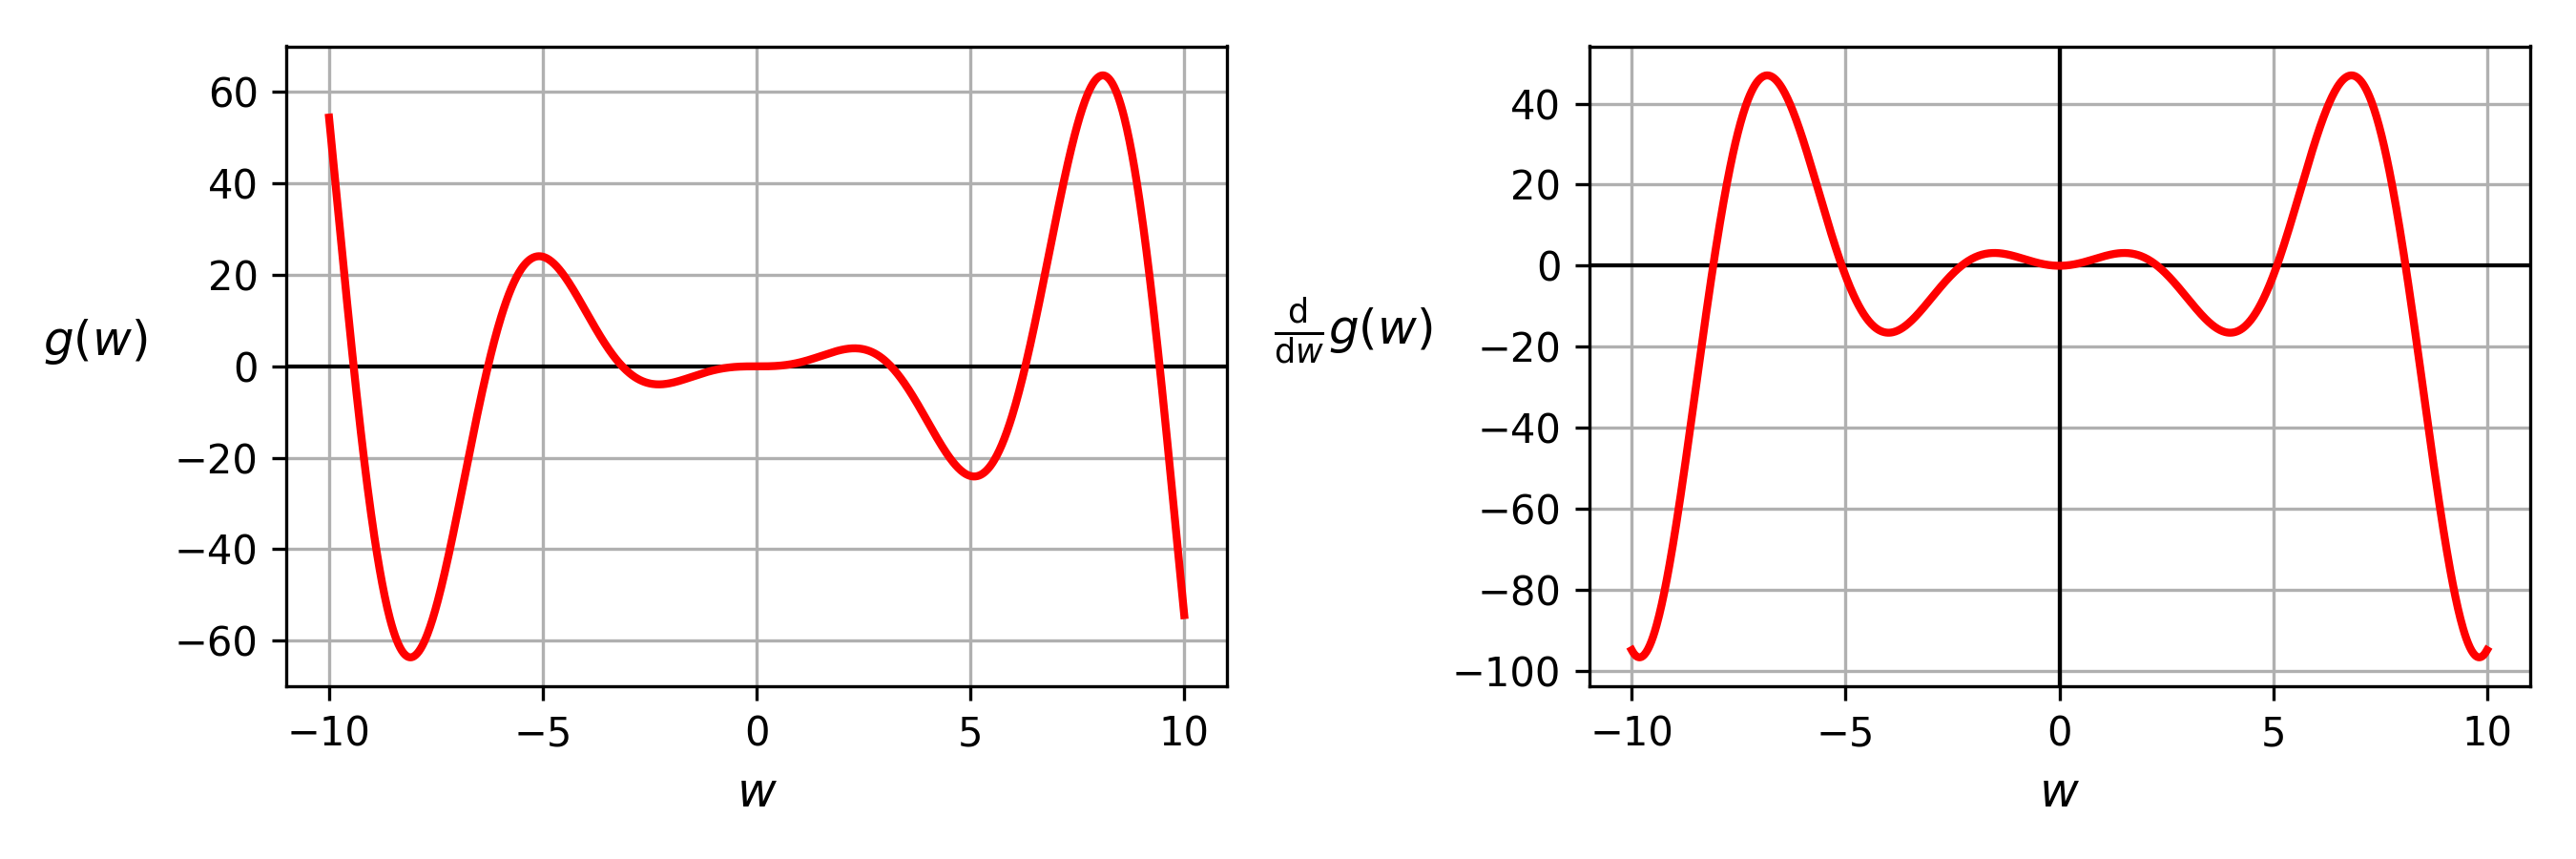

In [27]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w)*w**2

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

These examples

\begin{array}
\
g(w) =  \text{sin}(w^3) \\
g(w) = \text{tanh}(w)\text{cos}(w) + \text{log}(w) \\
g(w) =  \frac{\text{cos}(20w)}{w^2 + 1} \\
\end{array}

we previously computed by hand can now be nicely computed using our AD calculator.

<IPython.core.display.Javascript object>


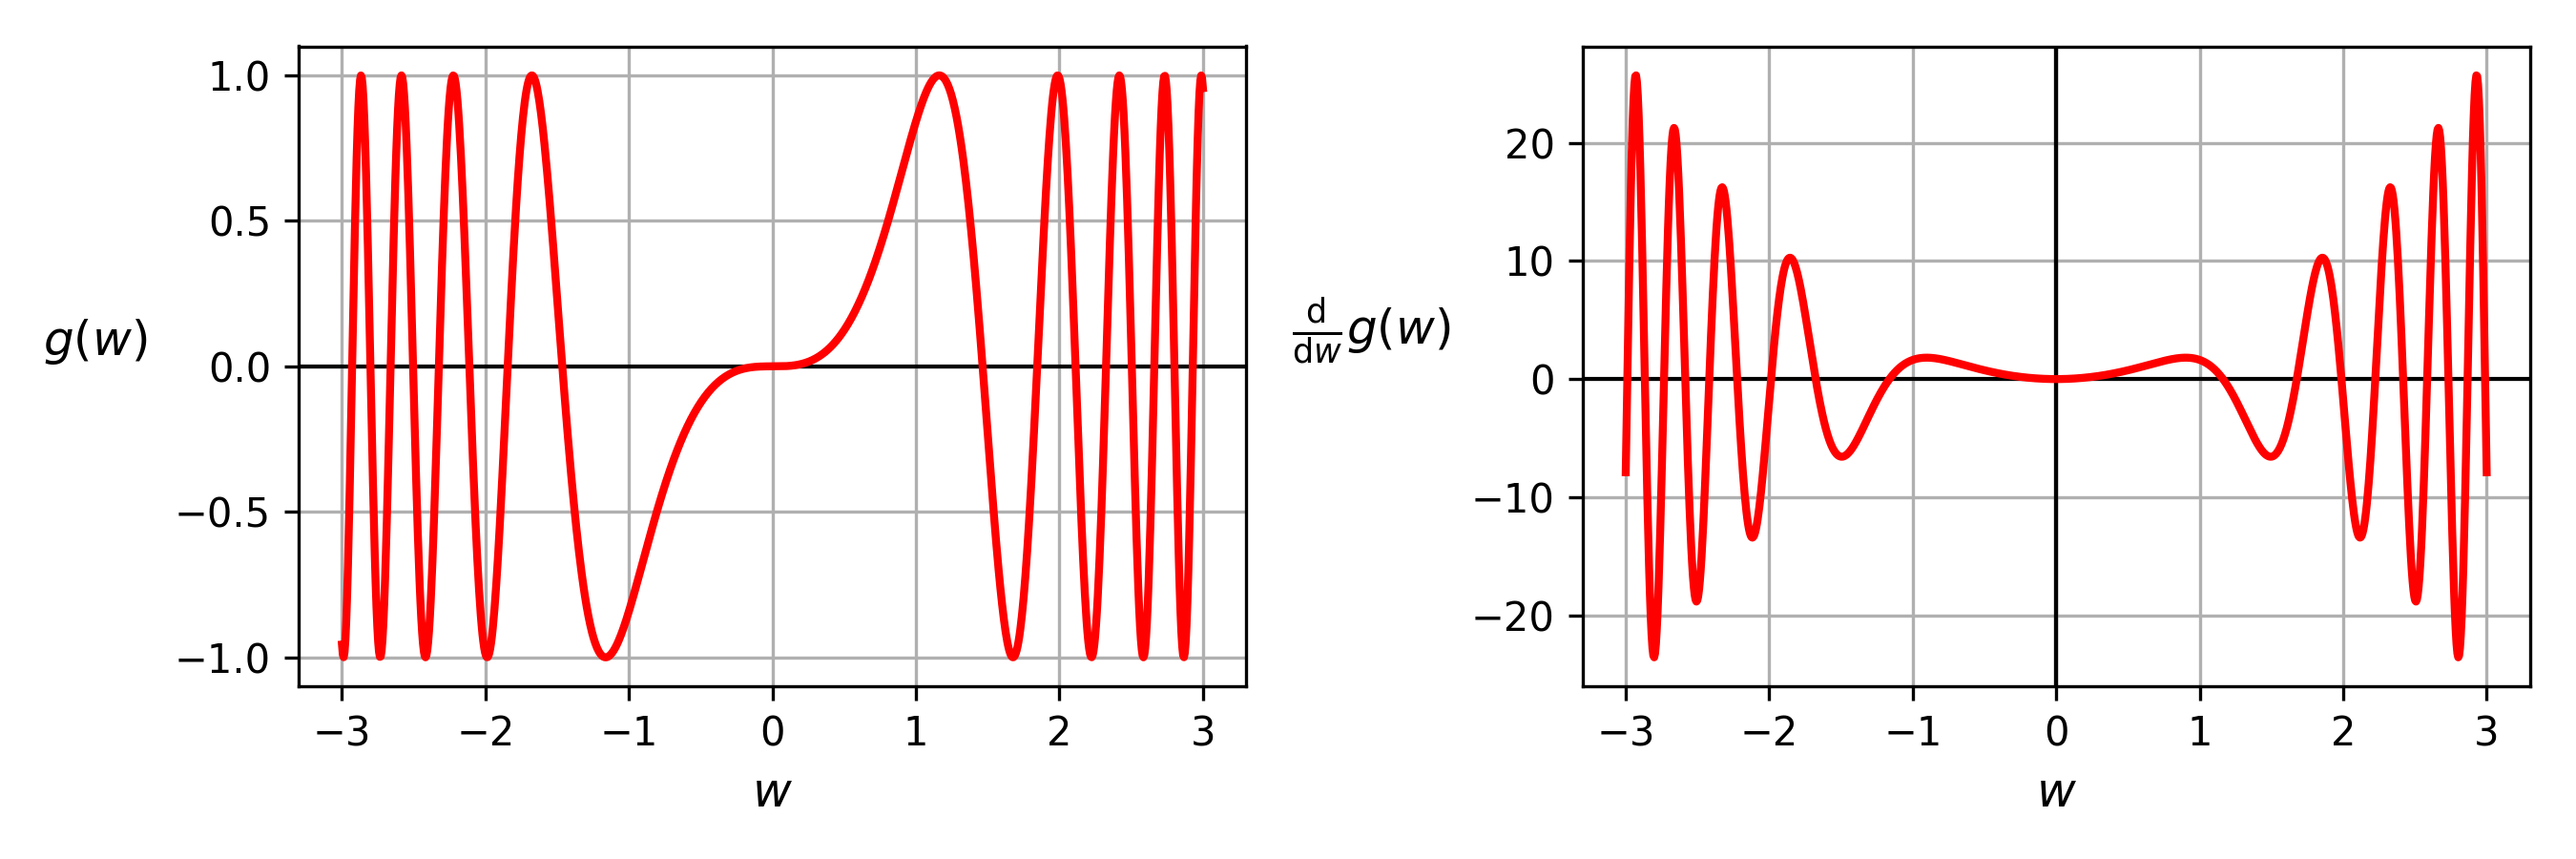

In [28]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w**3)

# use the custom plotting function above to plot over a large range of inputs
w = np.linspace(-3,3,1000)  # custom input range to plot over
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

<IPython.core.display.Javascript object>


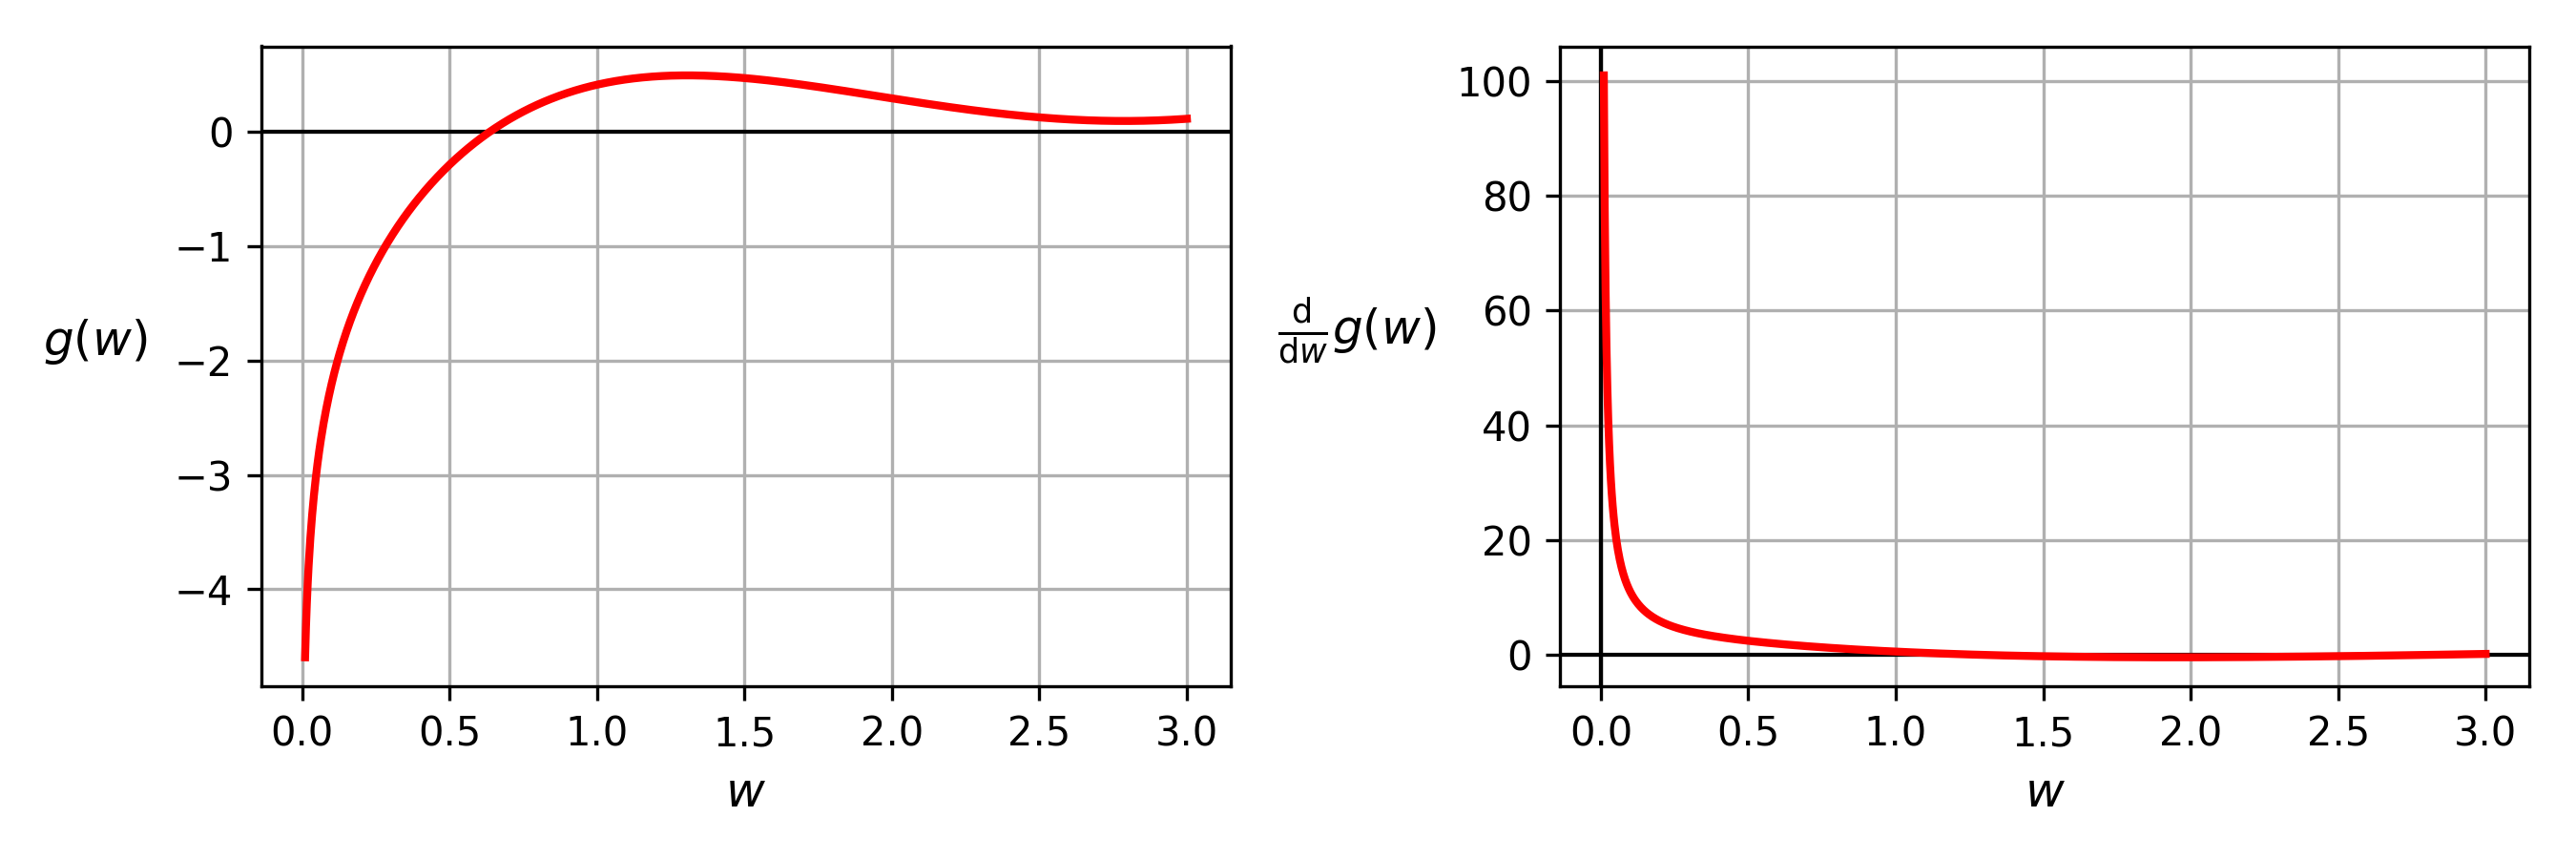

In [32]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w)*cos(w) + log(w)

# use the custom plotting function above to plot over a large range of inputs
w = np.linspace(0.01,3,1000)  # custom input range to plot over
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

<IPython.core.display.Javascript object>


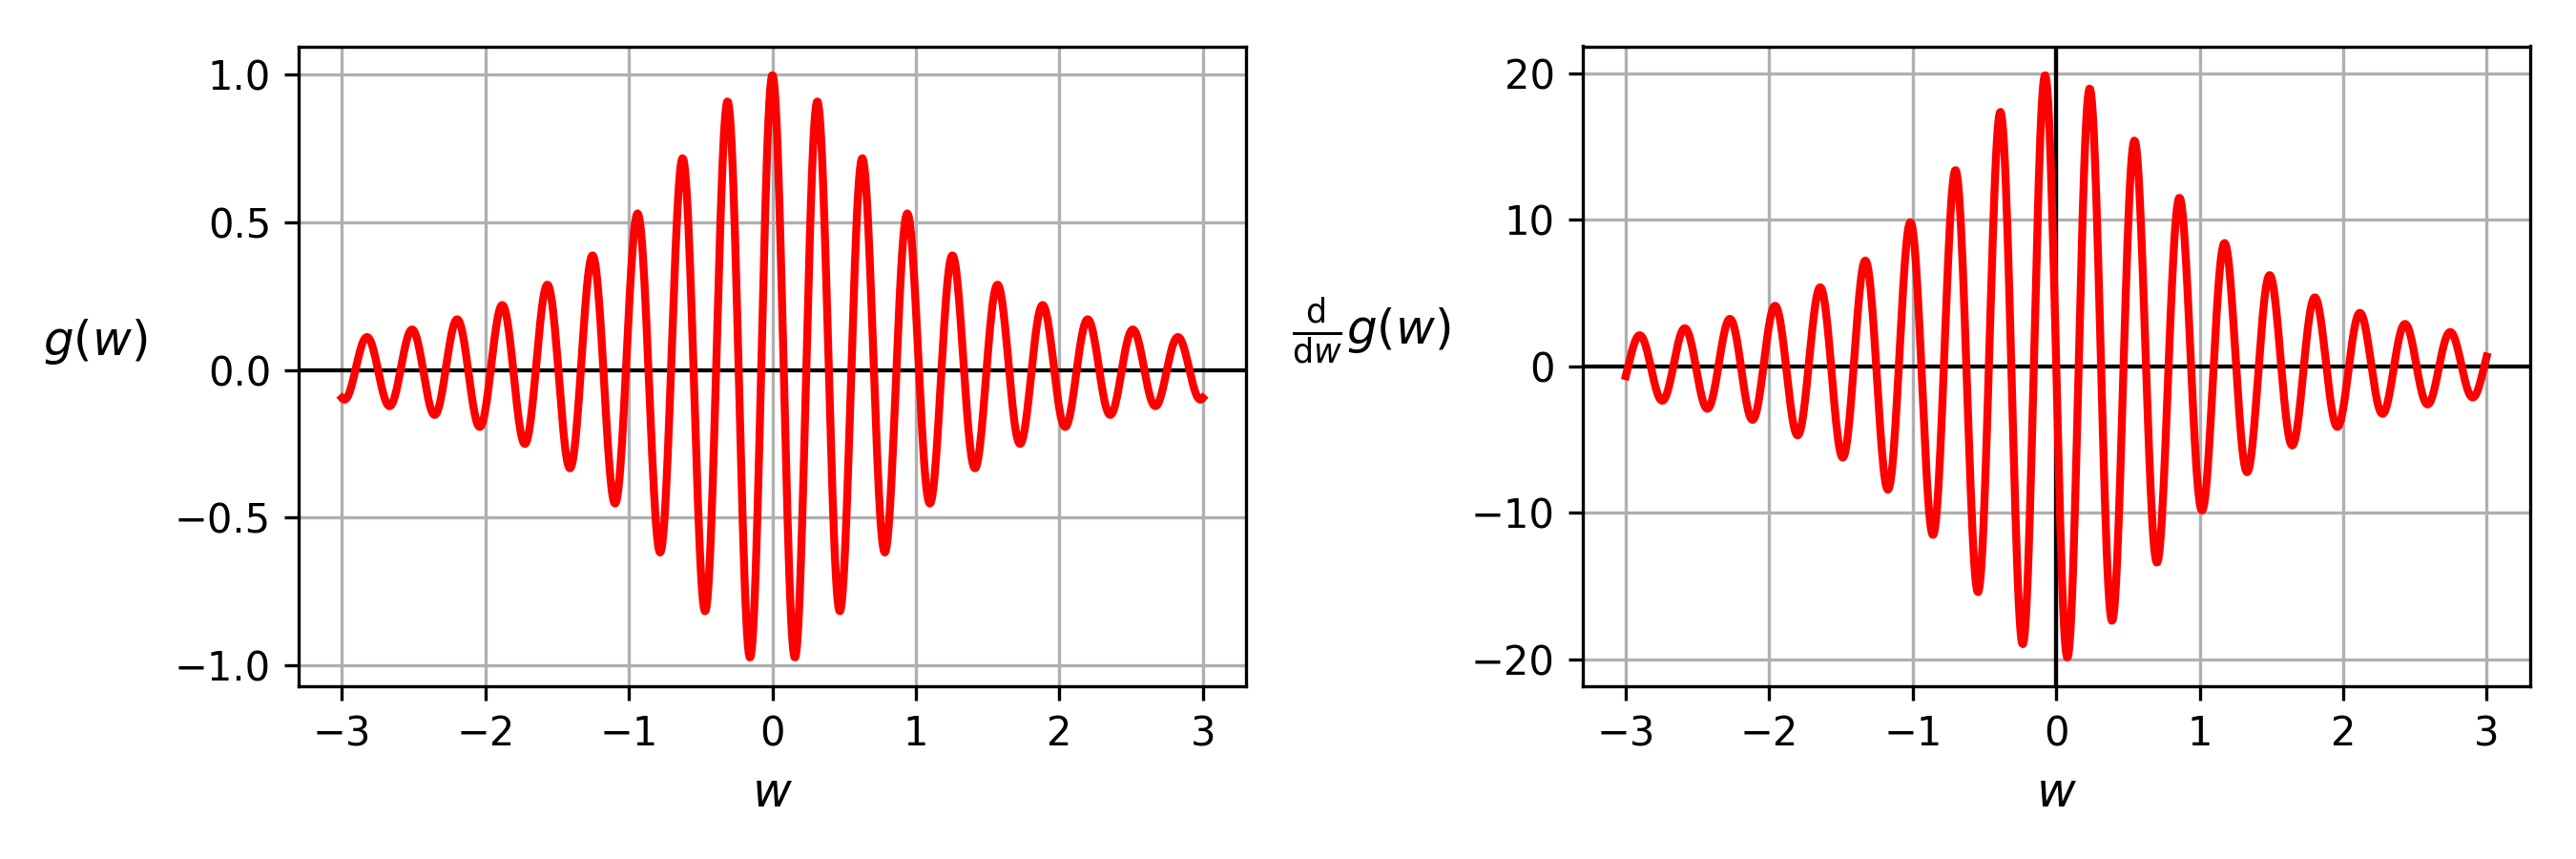

In [33]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: cos(20*w)*(w**2 + 1)**(-1)

# use the custom plotting function above to plot over a large range of inputs
w = np.linspace(-3,3,1000)    # custom input range to plot over
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)